In [1]:
%matplotlib inline
import numpy as np
import decimal
import matplotlib.pyplot as plt
from scipy import interpolate as intp
from scipy import stats
import seaborn as sns
from itertools import compress
from matplotlib.pyplot import cm
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import *

import torch
import torchvision
import torchvision.transforms as transforms

import cv2
from scipy.io import loadmat
from scipy.io import savemat
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def expandN_dims(x,N):
    """
    Add N extra dimensions to x
    """
    dims = np.shape(x.shape)[0] 
    for i in range(N):
        x = np.expand_dims(x,axis=dims+i)
    return x

def vonMisesFn(x,amp,scale,theta0):
    """
    Von Mises function, but for orientations
    x goes from (0, pi)
    """
    return amp*np.exp(scale*np.cos(2*(x-theta0)))

In [3]:
# Load the CIFAR features

fname = './Platinum_mouse_GNN_data/EstimatedCIFARFeatures.mat'
Data = loadmat(fname)
CMapReq_U = Data['CMapReq']
OMapReq_U = Data['OMapReq']
del Data

In [4]:
# Load the Tuning properties and population information for a given scan

# scan_name = '18142_7_2'
scan_name = '17797_6_8' 

fname = './Platinum_mouse_GNN_data/TuningProperties_' + scan_name + '.mat'
data = loadmat(fname)

# Tuning properties of all the neurons for which RFs were computed
AmpVec = data['AmpVec']
KVec = data['KVec']
ThetaVec = data['ThetaVec']
RxVec = data['RxVec'].squeeze()
RyVec = data['RyVec'].squeeze()

# Population information
id_PPC = data['id_PPC']
id_PPC = id_PPC.squeeze()
del data

In [5]:
# Compute the number of neurons in each population

Npops = len(id_PPC)
NNeu_Pops = np.zeros(Npops)
for i in range(Npops):
    NNeu_Pops[i] = len(id_PPC[i].squeeze())
print(NNeu_Pops)

[ 77. 139.  96. 179. 230. 144.  54. 136. 101.]


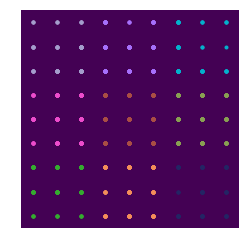

In [6]:
# Align the RF centers with 9x9 grid of CIFAR features

RxVec =  RxVec - np.min(RxVec[id_PPC[0].squeeze()])
RyVec = RyVec - np.min(RyVec[id_PPC[0].squeeze()])

# Plot the RF centers and show grouping of the PPCs
plt.figure()
plt.imshow(np.zeros([9,9]))
for i in range(Npops):
    plt.plot(RxVec[id_PPC[i]],RyVec[id_PPC[i]],color=tuple(np.random.rand(3)),marker='.',linestyle='None')
    
plt.axis('off')
plt.show()

In [7]:
"""
Compute projections of the mean population responses based on stimulus features

1. Compute the mean responses based on the tuning curves from the selected (typically high contrast) contrast bins. 
2. Compute the cos and sin statistics for mean neural responses
"""

s_bin = 1 #selected bin
normalizeByNNeu = 1 #scale the population parameters to average no. of neurons in each population

Nimages = CMapReq_U.shape[0]
NNeu = RxVec.shape[0]

# 1. Compute mean responses FF_Req for the neurons in the populations, for all the images
FF_Req = np.zeros([Nimages,NNeu])

for j in range(Npops):
    NIds = id_PPC[j].squeeze()
    for k in range(len(NIds)):
        nn = NIds[k] #neuron idx
        px = np.int(RxVec[nn])
        py = np.int(RyVec[nn])
        FF_Req[:,nn] = (CMapReq_U[:,py,px]/256.)*vonMisesFn(OMapReq_U[:,py,px]*np.pi/256.,AmpVec[nn,s_bin],KVec[nn,s_bin],ThetaVec[nn,s_bin])

        
# 2. Compute the cos and sin parameters
FF_cos = np.zeros([len(id_PPC), Nimages])
FF_sin = np.zeros([len(id_PPC), Nimages])

for ii in range(len(id_PPC)):
    idx = id_PPC[ii].squeeze()
    ThetaPPC = expandN_dims(ThetaVec[idx,s_bin],1).T
    KPPC = expandN_dims(KVec[idx,s_bin],1).T
    
    if normalizeByNNeu:
        Z = len(idx)/np.mean(NNeu_Pops)
    else:
        Z = 1
    
    FF_cos[ii,:] = np.sum(FF_Req[:,idx]*KPPC*np.cos(2*ThetaPPC),axis=1)/Z
    FF_sin[ii,:] = np.sum(FF_Req[:,idx]*KPPC*np.sin(2*ThetaPPC),axis=1)/Z

In [8]:
mdict = {'FF_cos': FF_cos, 'FF_sin': FF_sin}
fname = './Platinum_mouse_GNN_data/PopulationResponsestoCIFAR_'+scan_name+'.mat'
savemat(fname, mdict)

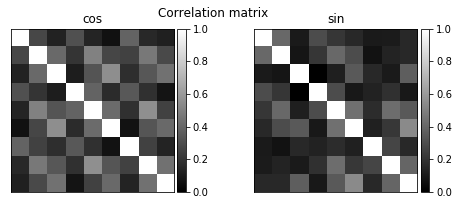

In [42]:
# Plot example image, estimated orientation and orientation maps
fig, axes = plt.subplots(1,2,figsize=[8,3])
fig.suptitle('Correlation matrix')
im = axes[0].imshow(np.corrcoef(FF_cos),cmap='gray',vmin=0,vmax=1)
axes[0].set_xticks([]); axes[0].set_yticks([])
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axes[0].set_title('cos')

im = axes[1].imshow(np.corrcoef(FF_sin),cmap='gray',vmin=0,vmax=1)
axes[1].set_xticks([]); axes[1].set_yticks([])
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axes[1].set_title('sin')

plt.show()